In [22]:
import gzip
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import *
from pyBioInfo.IO.File import GffFile, BedFile
from pyBioInfo.Utils import ShiftLoader

# Make HG001 inversion reference from cell paper

Porubsky, D., W. Höps, H. Ashraf, P. Hsieh, B. Rodriguez-Martin, F. Yilmaz, J. Ebler, et al. "Recurrent Inversion Polymorphisms in Humans Associate with Genetic Instability and Genomic Disorders." [In eng]. Cell 185, no. 11 (May 26 2022): 1986-2005.e26.


In [23]:
dat = pd.read_excel("data/inversions_from_cell_paper.xlsx", sheet_name="2AGRCh38_unifiedCallset")
f_gff = "results/inversions_from_porubsky/inversions_cell_paper.gff"
with open(f_gff, "w+") as fw:
    for chrom, start, end, iden in dat[["seqnames", "start", "end", "inv_id"]].values:
        attributes = "ID=%s" % iden
        row = [chrom, "CellPaper", "Inversion", start + 1, end, ".", "+", ".", attributes]
        line = "\t".join(map(str, row))
        fw.write(line + "\n")    
! bgzip -f {f_gff}
! tabix -p gff -f {f_gff}.gz

In [24]:
dat = pd.read_excel("data/inversions_from_cell_paper.xlsx", sheet_name="2AGRCh38_unifiedCallset")
availables = ["1|0", "1|1", "0|1", "1|0_lowconf", "1|1_lowconf", "0|1_lowconf"]
dat = dat[dat["NA12878"].isin(availables)]
f_gff = "results/inversions_from_porubsky/inversions_na12878.gff"
with open(f_gff, "w+") as fw:
    for chrom, start, end, iden, gt in dat[["seqnames", "start", "end", "inv_id", "NA12878"]].values:
        attributes = "ID=%s;GenoType=%s" % (iden, gt)
        row = [chrom, "CellPaper", "Inversion", start + 1, end, ".", "+", ".", attributes]
        line = "\t".join(map(str, row))
        fw.write(line + "\n")    
! bgzip -f {f_gff}
! tabix -p gff -f {f_gff}.gz

# Make inversions gff for NanoStrand-seq callsets

In [25]:
ncells = [50, 100, 150, 200, 250, 300, 350]
for ncell in ncells:
    f_bed = "../../4_NanoStrandSeq_Phasing/results/HG001_Cell_%d/inversions/inversions.bed.gz" % ncell
    f_gff = "results/inversions_from_directional/inversions_%d.gff" % ncell
    with gzip.open(f_bed, "rt") as f, open(f_gff, "w+") as fw:
        iden = 0
        for line in f:
            row = line.strip("\n").split("\t")
            chrom, start, end = row[:3]
            start, end = int(start), int(end)
            c, w, r = row[3].split(";")
            c = int(c)
            w = int(w)
            confident = True
            if c + w < 20:
                confident = False
            r = w / (c + w)
            if r >= 0.9:
                t = "HOM"
            elif r > 0.6:
                t = "Uncertain"
                confident = False
            elif r >= 0.4:
                t = "HET"
            else:
                t = "Uncertain"
                confident = False
            attributes = "ID=Inv.%d;Reads=%d;Crick=%d;Watson=%d;WatsonRatio=%f;Type=%s;Confident=%s" % (iden, c + w, c, w, r, t, confident)
            row = [chrom, "NanoStrand-seq", "Inversion", start + 1, end, ".", "+", ".", attributes]
            line = "\t".join(map(str, row))
            fw.write(line + "\n")
            iden += 1
    ! bgzip -f {f_gff}
    ! tabix -p gff -f {f_gff}.gz

# Benchmark of inversion

In [26]:
f_gff1 = "results/inversions_from_porubsky/inversions_na12878.gff.gz"
f_gff2 = "results/inversions_from_directional/inversions_350.gff.gz"

with GffFile(f_gff1) as f:
    inversions1 = [x for x in f]
    print(len(inversions1))

with GffFile(f_gff2) as f:
    inversions2 = []
    for x in f:
        # if int(x.attributes["Reads"]) >= 20 and float(x.attributes["WatsonRatio"]) >= 0.25:
        if x.attributes["Confident"] == "True":
            inversions2.append(x)
    print(len(inversions2))

131
339


In [27]:
ref = inversions1
que = inversions2
loader = ShiftLoader(que)
n = 0
for inv1 in ref:
    hit = False
    for inv2 in loader.fetch(obj=inv1):
        hit = True
    if hit:
        n += 1
print(len(ref), n, len(ref) - n, n / len(ref), sep="\t")
ref_count_all = len(ref)
ref_count_hit = n

ref = inversions2
que = inversions1
loader = ShiftLoader(que)
n = 0
for inv1 in ref:
    hit = False
    for inv2 in loader.fetch(obj=inv1):
        hit = True
    if hit:
        n += 1
print(len(ref), n, len(ref) - n, n / len(ref), sep="\t")
que_count_all = len(ref)
que_count_hit = n

131	70	61	0.5343511450381679
339	131	208	0.3864306784660767


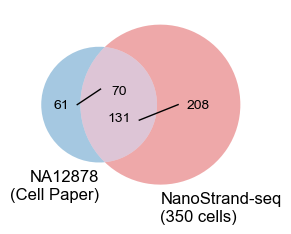

In [28]:
values = [ref_count_all - ref_count_hit, que_count_all - que_count_hit, (ref_count_hit + que_count_hit)/2]
plt.figure(figsize=(3, 3))
ret = venn2(values, set_colors=["C0", "C3"], set_labels=["NA12878\n(Cell Paper)", "NanoStrand-seq\n(350 cells)"])
ret.subset_labels[2].set_text("%s\n\n%s" % (ref_count_hit, que_count_hit))
plt.plot([0, 0.25], [-0.1, 0], lw=1, color="black")
plt.plot([-0.4, -0.25], [0, 0.1], lw=1, color="black")
plt.tight_layout()
plt.savefig("figures/benchmark_of_inversion.venn2.pdf", dpi=300)